In [6]:
# ✅ Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset


In [7]:
# ✅ Load model and tokenizer
model_path = "F:/MySelf/ai-customer-care/backend/models/roberta-sentiment"  
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [8]:
# ✅ Load and preprocess evaluation dataset
df = pd.read_csv("F:/MySelf/ai-customer-care/data/chat_datasets/customer_care_dataset_flat.csv")
df = df[["utterance", "emotion"]]
label2id = {label: i for i, label in enumerate(df["emotion"].unique())}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["emotion"].map(label2id)

def tokenize(example):
    return tokenizer(example["utterance"], truncation=True, padding="max_length", max_length=64)

dataset = Dataset.from_pandas(df[["utterance", "label"]])
dataset = dataset.map(tokenize)
eval_dataset = dataset.train_test_split(test_size=0.2, seed=42)["test"]

Map: 100%|██████████| 1386/1386 [00:00<00:00, 4235.74 examples/s]


In [9]:
# ✅ Define training args and load Trainer
training_args = TrainingArguments(output_dir="./models/roberta-sentiment")
trainer = Trainer(
    model=model,
    args=training_args
)

In [10]:
# Tokenize
encoded = tokenizer(eval_dataset["utterance"], padding=True, truncation=True, max_length=64, return_tensors="pt")
labels = torch.tensor(eval_dataset["label"])

In [11]:
# ✅ Run evaluation
predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

f:\MySelf\ai-customer-care\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 35/35 [00:10<00:00,  3.34it/s]


In [12]:
# 📊 Classification Report
print("Classification Report:")
print(classification_report(labels, preds, target_names=[str(id2label[i]) for i in sorted(id2label.keys())]))

Classification Report:
              precision    recall  f1-score   support

           6       0.06      0.08      0.07        36
           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00        51
           5       0.05      0.02      0.03        43
           4       0.80      0.87      0.83        52
           2       0.00      0.00      0.00        26
           3       0.02      0.03      0.03        29

    accuracy                           0.18       278
   macro avg       0.13      0.14      0.14       278
weighted avg       0.17      0.18      0.17       278



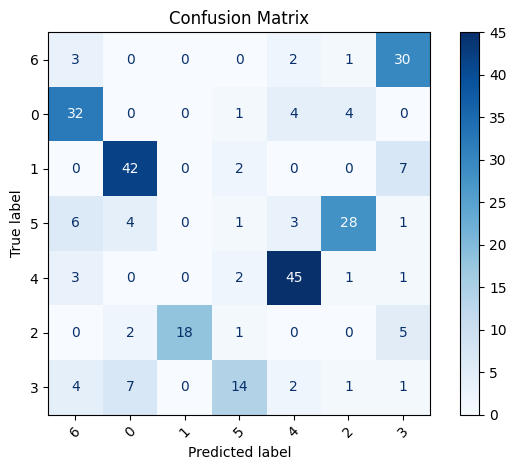

In [13]:
# 📉 Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(id2label[i]) for i in sorted(id2label.keys())])
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [14]:
# 🔥 ROC AUC Score
try:
    y_true = label_binarize(labels, classes=list(range(len(id2label))))
    y_scores = predictions.predictions  # Raw logits
    auc_score = roc_auc_score(y_true, y_scores, multi_class='ovr')
    print(f"🔥 ROC AUC Score (macro-averaged): {auc_score:.4f}")
except Exception as e:
    print("⚠️ Could not compute ROC AUC:", e)

🔥 ROC AUC Score (macro-averaged): 0.5081
